In [18]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
from sqlalchemy import create_engine

curs=['USD','GBP','AUD']
# 建立 SQLite 資料庫引擎
sql_cur = create_engine('sqlite:///exchange_rates.db')

for cur in curs:
    # 定義要抓取的 URL
    url = 'https://rate.bot.com.tw/xrt/quote/ltm/'+cur

    # 請求 HTML 内容
    response = requests.get(url)
    response.encoding = 'UTF-8'

    # 檢查請求是否成功
    if response.status_code == 200:
        sp = BeautifulSoup(response.text, 'lxml')
        print(sp.title.text)

    # 提取數據
        datas = sp.find_all('td', class_="rate-content-cash text-right print_table-cell")
        dates = sp.find_all('td', class_="text-center")

    # 創建字典以存储日期和匯率
        exchange_rates = {"日期": [], "買入": [], "賣出": []}

        for i in range(1, len(datas), 2):
            date = dates[i - 1].text.strip()  # 去除空白
            sell_rate_buy = float(datas[i - 1].text.strip())
            sell_rate_sell = float(datas[i].text.strip())
        
            exchange_rates["日期"].append(date)
            exchange_rates["買入"].append(sell_rate_buy)
            exchange_rates["賣出"].append(sell_rate_sell)

        # 創建 DataFrame
        out = pd.DataFrame(exchange_rates)

        # 將 '日期' 轉換為 datetime
        out['日期'] = pd.to_datetime(out['日期'], format='%Y/%m/%d')

        out.to_sql(cur, sql_cur, if_exists='replace', index=False)
        print("匯率數據已成功匯出至 '",cur,".sql'")

    else:
        print(f"數據提取失敗，狀態碼：{response.status_code}")
    


歷史本行營業時間牌告匯率
匯率數據已成功匯出至 ' USD .sql'
歷史本行營業時間牌告匯率
匯率數據已成功匯出至 ' GBP .sql'
歷史本行營業時間牌告匯率
匯率數據已成功匯出至 ' AUD .sql'


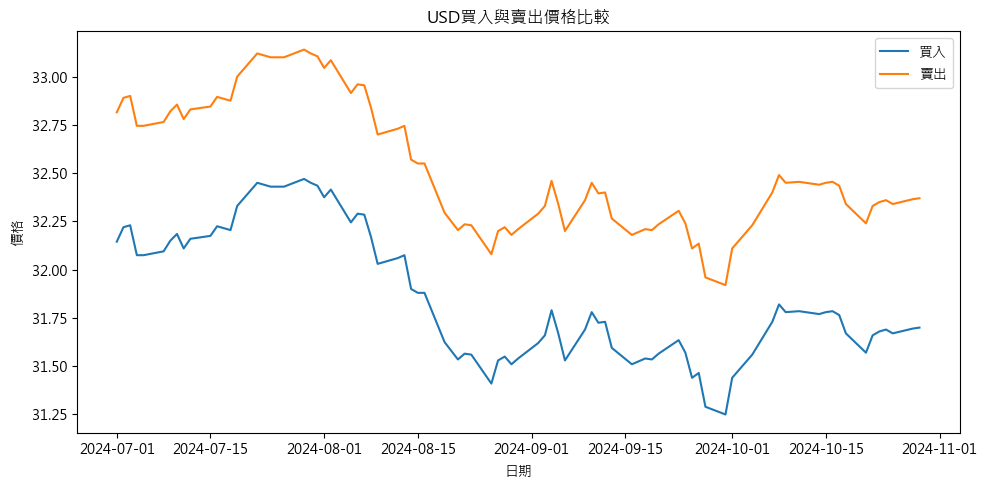

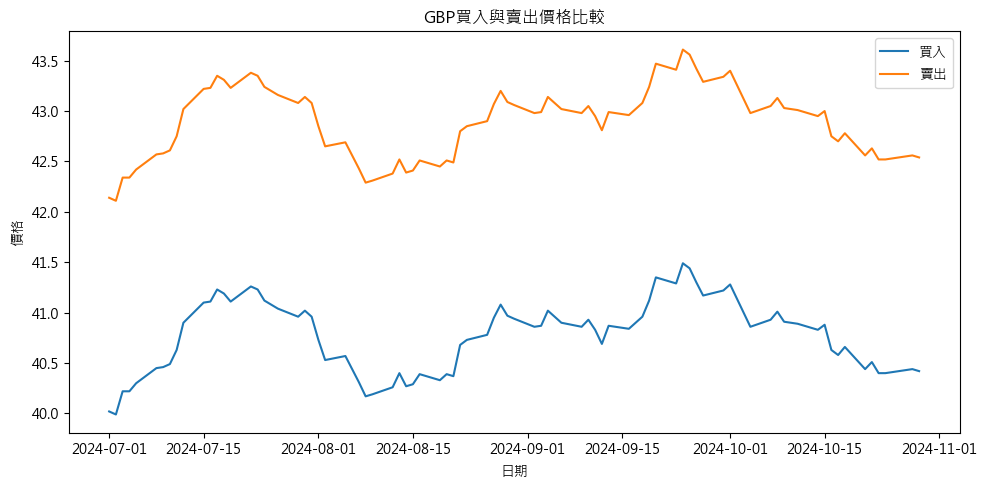

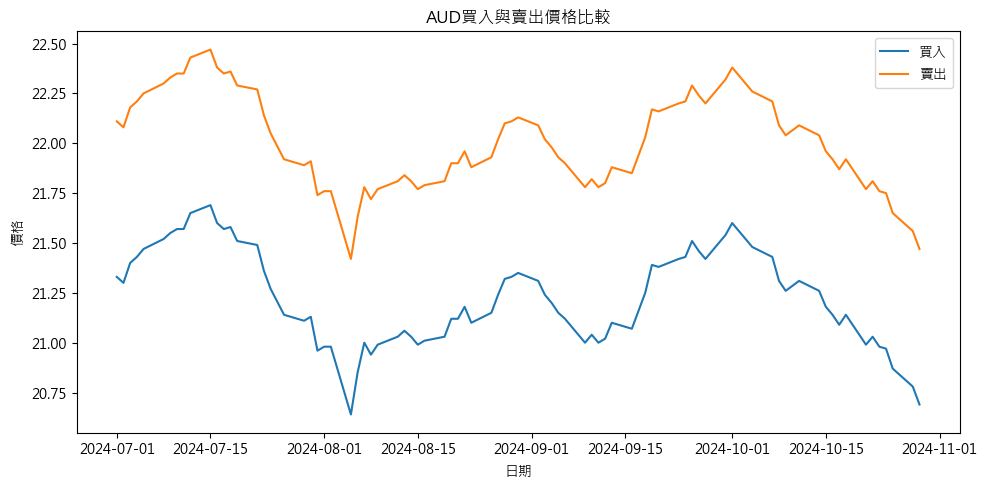

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine


curs=['USD','GBP','AUD']
sql_cur = create_engine('sqlite:///exchange_rates.db')

for cur in curs:
    # 從資料庫中讀取貨幣的數據
    query = f"SELECT * FROM {cur}"
    data = pd.read_sql(query, con=sql_cur)

    plt.rcParams["font.sans-serif"] = "Microsoft JhengHei"
    plt.rcParams["axes.unicode_minus"] = False
    plt.figure(figsize=(10, 5))
    data['日期'] = pd.to_datetime(data['日期'])

    # 繪製數據
    plt.plot(data["日期"], data["買入"], label="買入")
    plt.plot(data["日期"], data["賣出"], label="賣出")

    # 標記坐標軸
    plt.xlabel('日期')
    plt.ylabel('價格')
    plt.title(f'{cur}買入與賣出價格比較')

    # 顯示圖例並繪製圖形
    plt.legend()
    plt.tight_layout()
    plt.show()

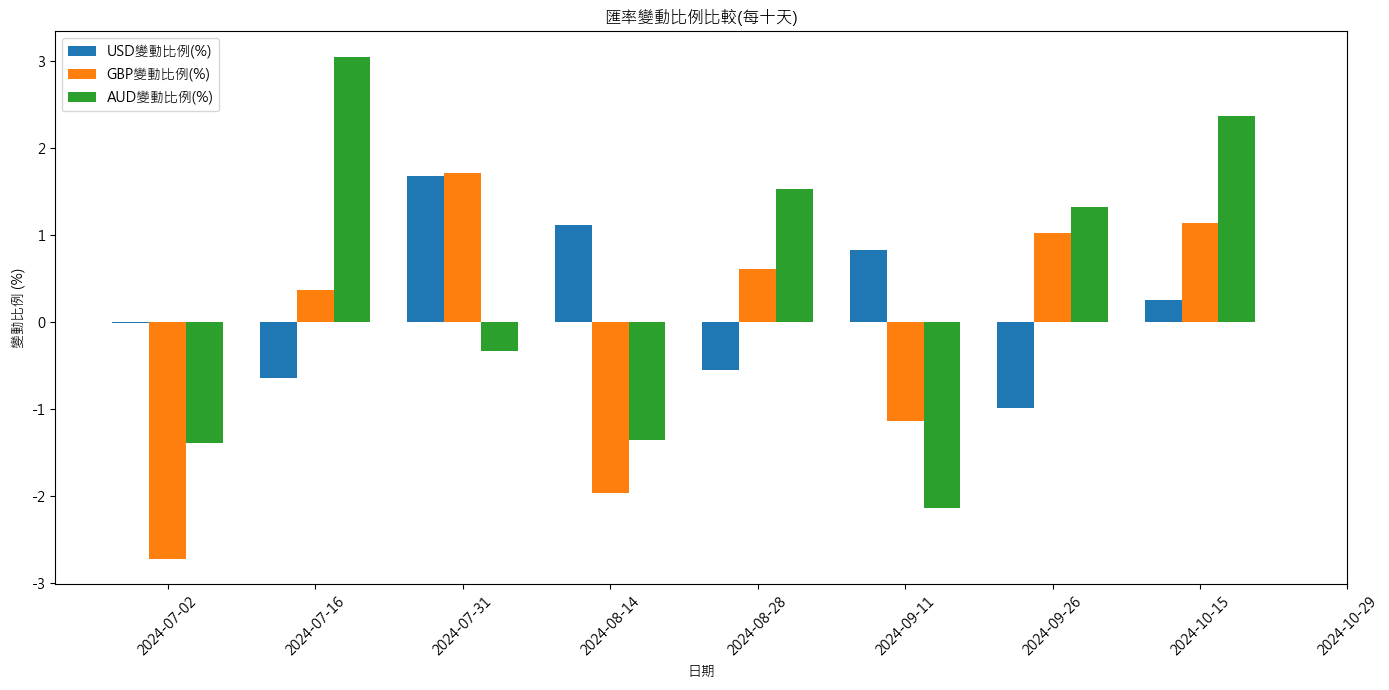

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine

curs=['USD','GBP','AUD']
# 建立 SQLite 資料庫引擎
sql_cur = create_engine('sqlite:///exchange_rates.db')
# 用於儲存所有貨幣的變動比例數據
all_data = {}

for cur in curs:
    # 從資料庫中讀取每個貨幣的數據
    query = f"SELECT * FROM {cur}"
    df = pd.read_sql(query, con=sql_cur)
    df['日期'] = pd.to_datetime(df['日期'])
    df.set_index('日期', inplace=True)  # 設置日期為索引

    # 計算每10天的變動比例
    df['買入變動比例(%)'] = df['買入'].pct_change(periods=10) * 100
    df['賣出變動比例(%)'] = df['賣出'].pct_change(periods=10) * 100
    
    df = df.iloc[::10]
    df['貨幣'] = cur
    all_data[cur] = df

# 合併所有貨幣的變動比例數據
combined_data = pd.concat(all_data.values()).sort_index()

# 設置繪圖參數
plt.rcParams["font.sans-serif"] = "Microsoft JhengHei" 
plt.rcParams["axes.unicode_minus"] = False  # 設置以顯示負號

# 繪製柱狀圖
width = 0.25  # 設置每個柱狀圖的寬度
x_labels = combined_data.index.unique()  # 獲取唯一的日期
x = np.arange(len(x_labels))  # x 軸的位置

plt.figure(figsize=(14, 7))

for i, cur in enumerate(curs):
    # 過濾出每種貨幣的數據
    currency_data = combined_data[combined_data['貨幣'] == cur]
    
    # 繪製買入變動比例的柱狀圖，併排顯示
    plt.bar(x + i * width, currency_data['買入變動比例(%)'], width=width, label=f"{cur}變動比例(%)")

plt.xlabel("日期")
plt.ylabel("變動比例 (%)")
plt.title(f"匯率變動比例比較(每十天)")
plt.xticks(x + width, x_labels.strftime('%Y-%m-%d'), rotation=45)  # 設置 x 軸標籤
plt.legend()
plt.tight_layout()
plt.show()

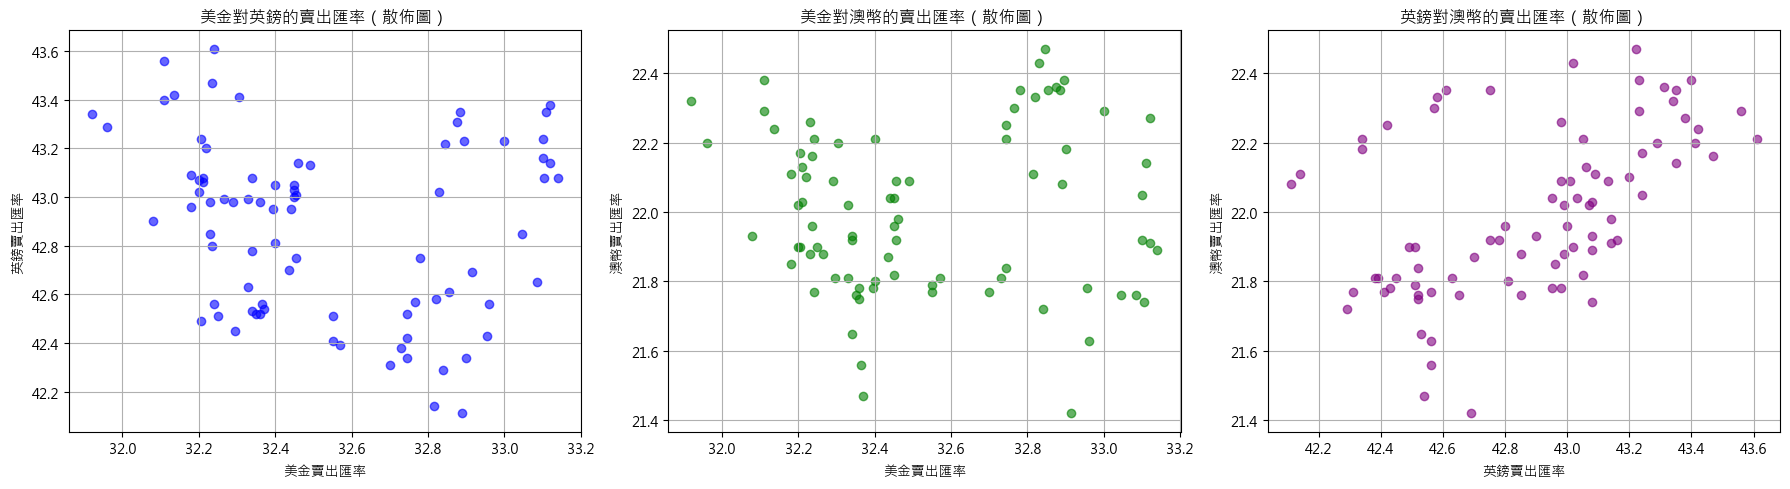

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

curs = ['USD', 'GBP', 'AUD']  # 美金、英鎊、澳幣
# 建立 SQLite 資料庫引擎
sql_cur = create_engine('sqlite:///exchange_rates.db')
all_data = {}

for cur in curs:
    # 從資料庫中讀取每個貨幣的數據
    query = f"SELECT * FROM {cur}"
    data = pd.read_sql(query, con=sql_cur)
    data['日期'] = pd.to_datetime(data['日期'])
    data.set_index('日期', inplace=True)  # 設置日期為索引
    
    data['貨幣'] = cur
    all_data[cur] = data[['賣出']]  # 只提取賣出匯率以便後續比較

# 將所有貨幣的資料合併到一個 DataFrame 中，對齊日期
combined_data = pd.concat(all_data, axis=1)
combined_data.columns = ['賣出_USD', '賣出_GBP', '賣出_AUD']  # 重命名列

# 設置繪圖參數
plt.figure(figsize=(18, 5))  # 設定圖形大小
plt.rcParams["font.sans-serif"] = "Microsoft JhengHei" 

# 1. 美金對英鎊的賣出匯率散佈圖
plt.subplot(1, 3, 1)  # 創建第一個子圖
plt.scatter(combined_data['賣出_USD'], combined_data['賣出_GBP'], color='blue', alpha=0.6)
plt.title("美金對英鎊的賣出匯率（散佈圖）")
plt.xlabel("美金賣出匯率")
plt.ylabel("英鎊賣出匯率")
plt.grid(True)  # 顯示網格線

# 2. 美金對澳幣的賣出匯率散佈圖
plt.subplot(1, 3, 2)  # 創建第二個子圖
plt.scatter(combined_data['賣出_USD'], combined_data['賣出_AUD'], color='green', alpha=0.6)
plt.title("美金對澳幣的賣出匯率（散佈圖）")
plt.xlabel("美金賣出匯率")
plt.ylabel("澳幣賣出匯率")
plt.grid(True)

# 3. 英鎊對澳幣的賣出匯率散佈圖
plt.subplot(1, 3, 3)  # 創建第三個子圖
plt.scatter(combined_data['賣出_GBP'], combined_data['賣出_AUD'], color='purple', alpha=0.6)
plt.title("英鎊對澳幣的賣出匯率（散佈圖）")
plt.xlabel("英鎊賣出匯率")
plt.ylabel("澳幣賣出匯率")
plt.grid(True)

plt.tight_layout()  # 自動調整子圖間距
plt.show()  # 顯示圖形

